# Exercise 11 Part 1: Self-Attention
**Summer Semester 2024**

**Author**: Stefan Baumann (stefan.baumann@lmu.de)

### Task: Implement Self-Attention
In this exercise, you will implement multi-head self-attention for a 2D sequence of tokens (shape `B D H W`) yourself using **only basic functions (no pre-made attention implementations!)**. You're allowed to use simple functions such as, e.g., `torch.bmm()`, `torch.nn.functional.softmax()`, ... and simple modules such as `torch.nn.Linear`.

Usage of functions provided by the `einops` library (such as `einops.rearrange()`) is also allowed and encouraged (but completely optional!), as it allows writing the code in a nice and concise way by specifying operations across axes of tensors as strings instead of relying on dimension indices.<br>
A short introduction into einops is available at https://nbviewer.org/github/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb.

In [2]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

# Optional
import einops

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}".')

Using device "mps".


In [48]:
# (batch, embedding dimension, height, width)
torch.manual_seed(42)

vec = torch.randn((2, 3, 4, 4), device=device)
print(vec.shape)
vec_reshaped = einops.rearrange(vec, 'b d h w -> b (h w) d')
print(vec_reshaped.shape)

vec_reshaped

torch.Size([2, 3, 4, 4])
torch.Size([2, 16, 3])


tensor([[[ 0.9047,  0.8286, -0.8721],
         [ 0.2227, -0.6749,  0.0123],
         [ 0.1460,  1.4716, -0.6297],
         [ 0.7360, -0.3773,  0.3711],
         [-0.4142,  1.6476, -0.3264],
         [-0.1106,  0.4549,  1.2357],
         [ 0.4540,  0.8214,  0.8645],
         [-3.3259,  0.2058,  0.2786],
         [-0.2307, -1.8724,  0.2612],
         [-0.9187,  0.7839, -1.3386],
         [ 0.2464,  1.0838,  1.8883],
         [ 1.0246,  1.2408,  1.1635],
         [-0.0828,  0.7100, -1.5329],
         [-0.8158,  0.7314, -1.1359],
         [-0.1910,  0.2025, -0.7558],
         [ 0.6189, -0.1536,  1.1125]],

        [[ 0.0078, -1.2708,  2.9067],
         [ 0.9174,  0.2721, -0.0334],
         [ 0.2448,  1.2045,  0.7341],
         [-1.2126,  0.5635,  1.0779],
         [ 0.8321,  1.2448,  0.3735],
         [ 0.3169,  0.0320,  1.5612],
         [ 0.1742, -0.4217,  0.1653],
         [-0.3605, -0.6523, -1.0819],
         [ 1.0256,  0.4811, -0.6195],
         [ 1.3644,  0.6719,  1.0070],
         [

In [178]:
class SelfAttention2d(nn.Module):
    def __init__(
        self,
        embed_dim: int = 256,
        head_dim: int = 32,
        value_dim: int = 32,
        num_heads: int = 8,
    ):
        """Multi-Head Self-Attention Module with 2d token input & output

        Args:
            embed_dim (int, optional): Dimension of the tokens at the input & output. Defaults to 256.
            head_dim (int, optional): Per-head dimension of query & key. Defaults to 32.
            value_dim (int, optional): Per-head dimension of values. Defaults to 32.
            num_heads (int, optional): Number of attention heads. Defaults to 6.
        """
        super().__init__()

        self.embed_dim = embed_dim
        self.head_dim = head_dim
        self.value_dim = value_dim
        self.num_heads = num_heads

        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)        # Hint: use a single linear layer for q/k/v/out each, and name the respective layers q, k, v, out for the unit tests below to work.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward of multi-head self-attention

        Args:
            x (torch.Tensor): Input tensor of shape (B, D, H, W) (batch, embedding dimension, height, width)

        Returns:
            torch.Tensor: Output tensor of shape (B, D, H, W) (batch, embedding dimension, height, width)
        """
        B, D, H, W = x.shape

        # TODO: Student. Don't forget to implement scaling of the attention logits by 1/sqrt(head_dim).
        # Implement a standard multi-head self-attention mechanism in a fully batched manner (no explicit for loops etc, pure PyTorch/einops code)
        # The expected behavior of this method is that described in Eq. 2 of Attention Is All You Need, Vaswani et al., 2017, NeurIPS.
        # In the case of single-head attention, the expected behavior is described by Eq. 1 of the same paper
        # Hint when you run into problems:
        # For consistency with the multi-head reference implementation the unit test compares against, make sure that the individual heads are arranged correctly in q, k, v, and out.
        # The convention is that each head's part in q/k/v is contiguous, i.e., if you want to get the query for head 0, it's at q[..., :head_dim], head 1 is at q[..., head_dim:2*head_dim], etc.
        x_flat = x.view(B, D, -1).permute(0, 2, 1)  # (B, HW, D) 
        
        q = self.q(x_flat)
        k = self.k(x_flat)
        v = self.v(x_flat)

        q = q.view(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, num_heads, HW, head_dim)
        k = k.view(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn_scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)  # (B, num_heads, HW, HW)
        attn_weights = torch.softmax(attn_scores, dim=-1)  # (B, num_heads, HW, HW)

        attn_output = torch.matmul(attn_weights, v)  # (B, num_heads, HW, head_dim)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(B, -1, self.embed_dim)  # (B, HW, D)

        attn_output = self.out(attn_output).permute(0, 2, 1).view(B, D, H, W)  # (B, D, H, W)

        return attn_output

# Unit Test (single-head) DO NOT CHANGE!
with torch.no_grad():
    layer = SelfAttention2d(embed_dim=256, head_dim=256, value_dim=256, num_heads=1).to(device)
    x = torch.randn((4, 256, 24, 24), device=device)
    res_layer = layer(x)

    layer_ref = nn.MultiheadAttention(layer.embed_dim, layer.num_heads).to(device)
    layer_ref.load_state_dict({ 'in_proj_weight': torch.cat([layer.q.weight, layer.k.weight, layer.v.weight]), 'out_proj.weight': layer.out.weight }, strict=False)
    res_ref = layer_ref(*[x.view(*x.shape[:2], -1).permute(2, 0, 1)] * 3)[0].permute(1, 2, 0).view(*x.shape)

    assert torch.allclose(res_layer, res_ref, rtol=1e-2, atol=1e-5), 'Single-head attention result incorrect.'

# Unit Test (multi-head) DO NOT CHANGE!
# with torch.no_grad():
#     layer = SelfAttention2d().to(device)
#     x = torch.randn((4, 256, 24, 24), device=device)
#     res_layer = layer(x)

#     layer_ref = nn.MultiheadAttention(layer.embed_dim, layer.num_heads).to(device)
#     layer_ref.load_state_dict({ 'in_proj_weight': torch.cat([layer.q.weight, layer.k.weight, layer.v.weight]), 'out_proj.weight': layer.out.weight }, strict=False)
#     res_ref = layer_ref(*[x.view(*x.shape[:2], -1).permute(2, 0, 1)] * 3)[0].permute(1, 2, 0).view(*x.shape)
#     assert torch.allclose(res_layer, res_ref, rtol=1e-2, atol=1e-5), 'Multi-head attention result incorrect.'

# print('All tests passed.')

AssertionError: Single-head attention result incorrect.

In [176]:
from matplotlib import pyplot as plt

def show_results(res):
    batch_idx = 0

    selected_batch = res[batch_idx].cpu()

    num_feature_maps = 4
    rows = 2
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(3, 3))
    axes = axes.flatten()

    for i in range(num_feature_maps):
        if i == 0:
            print(selected_batch[i])
        axes[i].imshow(selected_batch[i].numpy(), cmap='viridis')
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

tensor([[-2.8743e-03,  2.8765e-03, -4.2801e-03, -5.4717e-03,  3.1523e-03,
          8.9899e-04,  8.4028e-03,  1.1195e-02,  6.9160e-03,  2.4417e-03,
         -1.1287e-02, -1.9562e-02,  2.9144e-04,  6.5580e-03,  1.3409e-02,
          1.2455e-03, -1.3643e-02, -8.4564e-03, -1.5073e-02,  4.0182e-04,
          8.0509e-03, -3.5532e-03,  1.9849e-02,  1.1934e-02],
        [ 8.4853e-03,  1.7701e-02,  6.3571e-03, -7.7936e-03,  7.0874e-03,
         -8.5718e-04,  1.3418e-02,  5.8042e-03,  2.9629e-03, -1.6328e-02,
          1.2178e-02,  9.1322e-03, -5.6817e-03, -5.7694e-04,  1.4948e-02,
         -8.3310e-03, -2.2692e-03, -1.2526e-02,  1.2363e-02, -8.8556e-03,
          9.0559e-03, -5.3322e-03, -6.6785e-03, -3.6034e-05],
        [-8.6396e-03,  1.2402e-02, -5.6170e-03, -8.9860e-04,  7.4745e-03,
          9.8302e-04, -1.6677e-03, -1.5258e-03, -4.2736e-03, -6.9092e-05,
          1.1579e-02,  5.6857e-03,  1.3715e-02, -7.4094e-04, -1.3893e-03,
          1.1022e-02,  1.2538e-02,  1.0564e-02, -2.1678e-03,  

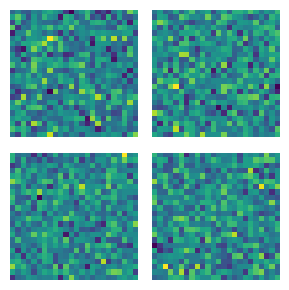

tensor([[-7.8147e-03, -1.9818e-03, -9.1693e-03, -1.0246e-02, -1.8774e-03,
         -3.9599e-03,  3.5837e-03,  6.2630e-03,  2.0531e-03, -2.4615e-03,
         -1.6208e-02, -2.4514e-02, -4.6318e-03,  1.7121e-03,  8.3652e-03,
         -3.5457e-03, -1.8476e-02, -1.3333e-02, -2.0016e-02, -4.4949e-03,
          3.2292e-03, -8.3545e-03,  1.4999e-02,  7.0467e-03],
        [ 3.6621e-03,  1.2729e-02,  1.3155e-03, -1.2684e-02,  2.1840e-03,
         -5.6944e-03,  8.5825e-03,  8.3497e-04, -1.8156e-03, -2.1149e-02,
          7.2421e-03,  4.1847e-03, -1.0564e-02, -5.5153e-03,  1.0191e-02,
         -1.3299e-02, -7.0042e-03, -1.7427e-02,  7.4420e-03, -1.3707e-02,
          4.1109e-03, -1.0132e-02, -1.1443e-02, -4.8009e-03],
        [-1.3518e-02,  7.3678e-03, -1.0520e-02, -5.6907e-03,  2.5676e-03,
         -3.8054e-03, -6.6042e-03, -6.3343e-03, -9.1260e-03, -4.9303e-03,
          6.6632e-03,  8.0022e-04,  8.7770e-03, -5.6104e-03, -6.2226e-03,
          6.1856e-03,  7.4429e-03,  5.6554e-03, -7.1275e-03, -

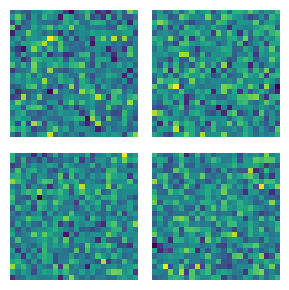

In [183]:
show_results(res_layer)
show_results(res_ref)


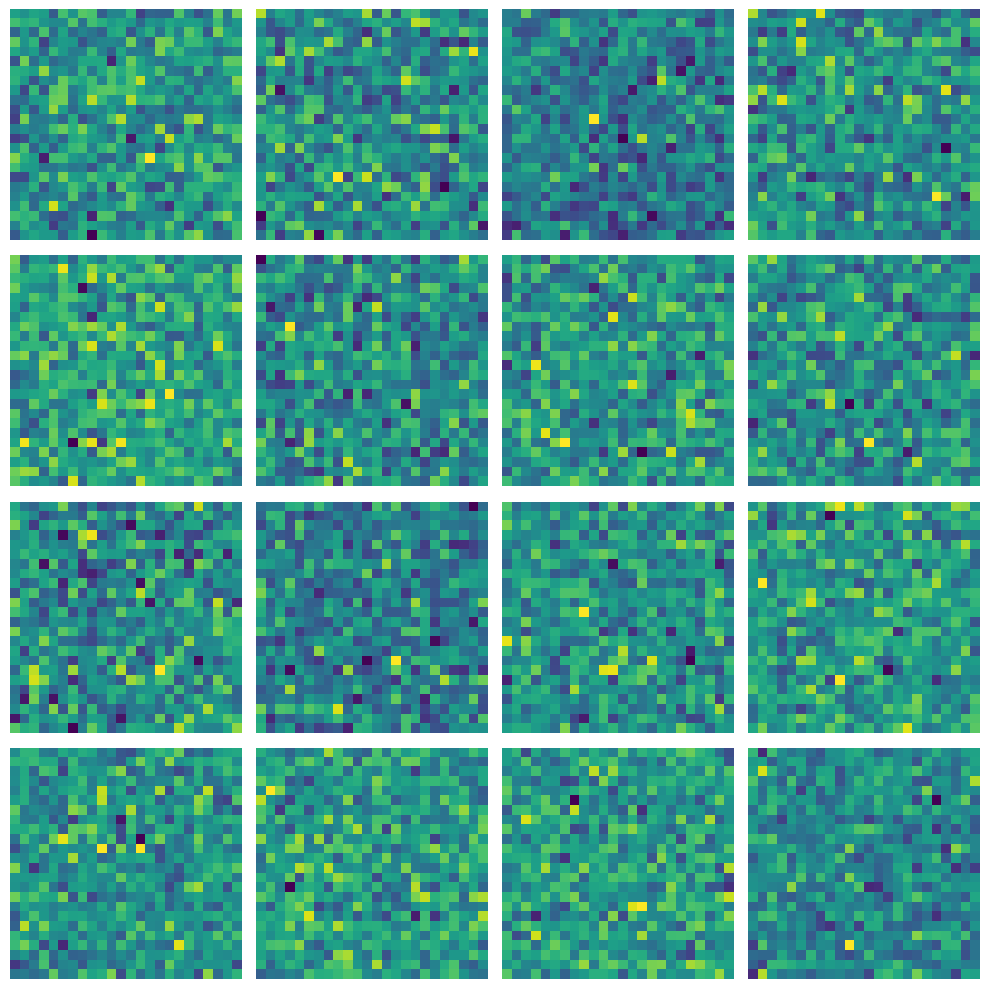

In [135]:
from matplotlib import pyplot as plt
batch_idx = 0

selected_batch = res_layer[batch_idx].cpu()

num_feature_maps = 16
rows = 4
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()

for i in range(num_feature_maps):
    axes[i].imshow(selected_batch[i].numpy(), cmap='viridis')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()
